In [ ]:
from google.colab import files
import os
import shutil
import zipfile
import pandas as pd # Para visualizar o CSV de metadados se necessário

# 1. Configurar o Kaggle API Token
print("Por favor, faça o upload do seu arquivo 'kaggle.json'.")
files.upload() # Uma caixa de diálogo irá aparecer para você selecionar o arquivo kaggle.json

# Criar o diretório .kaggle e mover o kaggle.json para lá
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # Dar permissões corretas ao arquivo

print("\nConfiguração do Kaggle API concluída.")

# 2. Baixar o dataset do Kaggle
# O nome do dataset é khanfashee/nih-chest-x-ray-14-224x224-resized
kaggle_dataset_name = 'khanfashee/nih-chest-x-ray-14-224x224-resized'
download_path = '/content/kaggle_data' # Diretório temporário para o download
os.makedirs(download_path, exist_ok=True)

print(f"Baixando o dataset '{kaggle_dataset_name}' do Kaggle...")
# -P para especificar o diretório de download
!kaggle datasets download -d {kaggle_dataset_name} -p {download_path}

# 3. Descompactar o dataset
zip_file_path = os.path.join(download_path, 'nih-chest-x-ray-14-224x224-resized.zip')
extracted_path = os.path.join(download_path, 'extracted') # Diretório para os dados extraídos
os.makedirs(extracted_path, exist_ok=True)

print(f"Descompactando o arquivo: {zip_file_path}")
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)
print("Descompactação concluída.")

# 4. Organizar os dados (criar a estrutura original_dataset_path)
# Vamos precisar de uma estrutura train/val/test e Cardiomegaly/No Finding
# Este dataset possui um CSV com as labels. Precisamos usá-lo para organizar.

# Carregar o CSV de metadados para obter as labels
csv_path = os.path.join(extracted_path, 'Data_Entry_2017_224x224.csv')
if not os.path.exists(csv_path):
    # Tenta um nome de arquivo diferente se o padrão não for encontrado
    # Pode ser algo como 'Data_Entry_2017.csv' ou similar no root do zip
    print(f"Aviso: {csv_path} não encontrado. Verificando o diretório extraído.")
    # Lista arquivos para depuração
    print(f"Arquivos em {extracted_path}: {os.listdir(extracted_path)}")
    # Assumindo que o CSV está no diretório extraído e pode ter um nome ligeiramente diferente
    csv_candidates = [f for f in os.listdir(extracted_path) if f.endswith('.csv')]
    if csv_candidates:
        csv_path = os.path.join(extracted_path, csv_candidates[0])
        print(f"Usando o arquivo CSV encontrado: {csv_path}")
    else:
        raise FileNotFoundError("Nenhum arquivo CSV de metadados encontrado no diretório extraído.")


df = pd.read_csv(csv_path)

# Filtrar para 'Cardiomegaly' e 'No Finding'
# A coluna 'Finding Labels' pode conter múltiplas labels separadas por '|'
df_filtered = df[df['Finding Labels'].isin(['Cardiomegaly', 'No Finding'])].copy()

# Mapear 'No Finding' para 'No Finding' e 'Cardiomegaly' para 'Cardiomegaly'
# Se houver outras labels, elas serão ignoradas pelo isin acima
# Criar uma coluna 'Target' que será 'Cardiomegaly' ou 'No Finding'
df_filtered['Target'] = df_filtered['Finding Labels']

print(f"\nDataFrame filtrado para Cardiomegaly e No Finding. Total de amostras: {len(df_filtered)}")
print(df_filtered['Target'].value_counts())



image_root_dirs = [os.path.join(extracted_path, d) for d in os.listdir(extracted_path) if 'images_' in d and os.path.isdir(os.path.join(extracted_path, d))]
print(f"\nDiretórios de imagem encontrados: {image_root_dirs}")

# Montar o Google Drive e criar diretórios de projeto/modelos
from google.colab import drive
drive.mount('/content/drive')

project_root = '/content/drive/MyDrive/Cardiomegaly_Project'
original_dataset_path = os.path.join(project_root, 'dataset_original')
model_save_path = os.path.join(project_root, 'models')

os.makedirs(os.path.join(original_dataset_path, 'train', 'Cardiomegaly'), exist_ok=True)
os.makedirs(os.path.join(original_dataset_path, 'train', 'No Finding'), exist_ok=True)
os.makedirs(os.path.join(original_dataset_path, 'validation', 'Cardiomegaly'), exist_ok=True)
os.makedirs(os.path.join(original_dataset_path, 'validation', 'No Finding'), exist_ok=True)
os.makedirs(os.path.join(original_dataset_path, 'test', 'Cardiomegaly'), exist_ok=True)
os.makedirs(os.path.join(original_dataset_path, 'test', 'No Finding'), exist_ok=True)
os.makedirs(model_save_path, exist_ok=True)

print(f"\nDiretórios criados no Drive para o projeto.")

# Dividir o DataFrame em treino, validação e teste
from sklearn.model_selection import train_test_split

# Estratificar para manter a proporção das classes
train_val_df, test_df = train_test_split(df_filtered, test_size=0.15, random_state=42, stratify=df_filtered['Target'])
train_df, val_df = train_test_split(train_val_df, test_size=0.176, random_state=42, stratify=train_val_df['Target']) # 0.176 de 0.85 é ~0.15 do total

print(f"\nDivisão dos dados:")
print(f"  Treino: {len(train_df)} ({train_df['Target'].value_counts()})")
print(f"  Validação: {len(val_df)} ({val_df['Target'].value_counts()})")
print(f"  Teste: {len(test_df)} ({test_df['Target'].value_counts()})")

# Função auxiliar para copiar imagens
def copy_images_to_dest(dataframe, dest_path, image_root_dirs):
    count = 0
    for idx, row in dataframe.iterrows():
        img_name = row['Image Index']
        label = row['Target']
        found = False
        for img_dir in image_root_dirs:
            src_path = os.path.join(img_dir, img_name)
            if os.path.exists(src_path):
                dest_subfolder = os.path.join(dest_path, label)
                os.makedirs(dest_subfolder, exist_ok=True) # Garante que a subpasta da classe exista
                shutil.copy(src_path, os.path.join(dest_subfolder, img_name))
                count += 1
                found = True
                break
        if not found:
            print(f"Aviso: Imagem {img_name} não encontrada em nenhum diretório de imagens.")
    print(f"Copiadas {count} imagens para {dest_path}")


print("\nCopiando imagens para os diretórios originais do dataset no Drive...")
copy_images_to_dest(train_df, os.path.join(original_dataset_path, 'train'), image_root_dirs)
copy_images_to_dest(val_df, os.path.join(original_dataset_path, 'validation'), image_root_dirs)
copy_images_to_dest(test_df, os.path.join(original_dataset_path, 'test'), image_root_dirs)

print("\nOrganização do dataset original no Drive concluída.")

Por favor, faça o upload do seu arquivo 'kaggle.json'.


A saída de streaming foi truncada nas últimas 5000 linhas.
Aviso: Imagem 00001295_000.png não encontrada em nenhum diretório de imagens.
Aviso: Imagem 00005537_011.png não encontrada em nenhum diretório de imagens.
Aviso: Imagem 00001829_001.png não encontrada em nenhum diretório de imagens.
Aviso: Imagem 00009239_007.png não encontrada em nenhum diretório de imagens.
Aviso: Imagem 00019271_066.png não encontrada em nenhum diretório de imagens.
Aviso: Imagem 00020113_020.png não encontrada em nenhum diretório de imagens.
Aviso: Imagem 00026092_001.png não encontrada em nenhum diretório de imagens.
Aviso: Imagem 00006277_003.png não encontrada em nenhum diretório de imagens.
Aviso: Imagem 00006468_000.png não encontrada em nenhum diretório de imagens.
Aviso: Imagem 00021618_000.png não encontrada em nenhum diretório de imagens.
Aviso: Imagem 00013982_005.png não encontrada em nenhum diretório de imagens.
Aviso: Imagem 00004240_000.png não encontrada em nenhum diretório de imagens.
Aviso

In [ ]:
from google.colab import files
import os
import shutil
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Configurar o Kaggle API Token (Já deve estar configurado se a sessão não foi reiniciada)
# print("Por favor, faça o upload do seu arquivo 'kaggle.json'.")
# files.upload() # Comentei esta linha, descomente se você reiniciou a sessão e precisa subir o JSON novamente

# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/ # Isso dará erro se o arquivo não foi carregado novamente
# !chmod 600 ~/.kaggle/kaggle.json

print("\nAssumindo que a configuração do Kaggle API já está concluída ou será feita se necessário.")


# 2. Baixar o dataset do Kaggle (Só se não foi baixado na última vez)
kaggle_dataset_name = 'khanfashee/nih-chest-x-ray-14-224x224-resized'
download_path = '/content/kaggle_data' # Diretório temporário para o download

# REMOVENDO E RECRIANDO O DIRETÓRIO DE DOWNLOAD PARA GARANTIR LIMPEZA
if os.path.exists(download_path):
    shutil.rmtree(download_path)
os.makedirs(download_path, exist_ok=True)


print(f"Baixando o dataset '{kaggle_dataset_name}' do Kaggle...")
# -P para especificar o diretório de download
!kaggle datasets download -d {kaggle_dataset_name} -p {download_path}

# 3. Descompactar o dataset
zip_file_path = os.path.join(download_path, 'nih-chest-x-ray-14-224x224-resized.zip')
extracted_path = os.path.join(download_path, 'extracted') # Diretório para os dados extraídos

# REMOVENDO E RECRIANDO O DIRETÓRIO EXTRAÍDO PARA GARANTIR LIMPEZA
if os.path.exists(extracted_path):
    shutil.rmtree(extracted_path)
os.makedirs(extracted_path, exist_ok=True)


print(f"Descompactando o arquivo: {zip_file_path}")
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)
print("Descompactação concluída.")

# 4. Organizar os dados (criar a estrutura de treino/validação/teste no ambiente Colab)
original_dataset_path = '/content/data' # Agora dentro do ambiente Colab
model_save_path = '/content/models' # Onde salvaremos os modelos

# REMOVENDO E RECRIANDO O DIRETÓRIO original_dataset_path PARA GARANTIR LIMPEZA
if os.path.exists(original_dataset_path):
    shutil.rmtree(original_dataset_path)
os.makedirs(os.path.join(original_dataset_path, 'train', 'Cardiomegaly'), exist_ok=True)
os.makedirs(os.path.join(original_dataset_path, 'train', 'No Finding'), exist_ok=True)
os.makedirs(os.path.join(original_dataset_path, 'validation', 'Cardiomegaly'), exist_ok=True)
os.makedirs(os.path.join(original_dataset_path, 'validation', 'No Finding'), exist_ok=True)
os.makedirs(os.path.join(original_dataset_path, 'test', 'Cardiomegaly'), exist_ok=True)
os.makedirs(os.path.join(original_dataset_path, 'test', 'No Finding'), exist_ok=True)
os.makedirs(model_save_path, exist_ok=True)

print(f"\nDiretório para dataset original no Colab: {original_dataset_path}")
print(f"Diretório para salvar modelos no Colab: {model_save_path}")

# Carregar o CSV de metadados para obter as labels
csv_candidates = [f for f in os.listdir(extracted_path) if f.endswith('.csv')]
if not csv_candidates:
    raise FileNotFoundError("Nenhum arquivo CSV de metadados encontrado no diretório extraído.")
csv_path = os.path.join(extracted_path, csv_candidates[0])
print(f"Usando o arquivo CSV encontrado: {csv_path}")

df = pd.read_csv(csv_path)

# Filtrar para 'Cardiomegaly' e 'No Finding'
df_filtered = df[df['Finding Labels'].isin(['Cardiomegaly', 'No Finding'])].copy()
df_filtered['Target'] = df_filtered['Finding Labels']

print(f"\nDataFrame filtrado para Cardiomegaly e No Finding. Total de amostras: {len(df_filtered)}")
print(df_filtered['Target'].value_counts())

# ********************************************************************************
# CORREÇÃO CRÍTICA AQUI: AJUSTAR O image_root_dirs COM BASE NA SUA ESTRUTURA
# ********************************************************************************
# Com base na imagem que você enviou, as imagens estão em 'extracted/images-224/images-224/'
image_root_dirs = [os.path.join(extracted_path, 'images-224', 'images-224')]

if not image_root_dirs[0] or not os.path.exists(image_root_dirs[0]):
    raise FileNotFoundError(f"Caminho da imagem principal não encontrado: {image_root_dirs[0]}. Verifique a estrutura do zip.")
print(f"\nDiretórios de imagem CORRIGIDOS: {image_root_dirs}")


# Dividir o DataFrame em treino, validação e teste
train_val_df, test_df = train_test_split(df_filtered, test_size=0.15, random_state=42, stratify=df_filtered['Target'])
train_df, val_df = train_test_split(train_val_df, test_size=0.176, random_state=42, stratify=train_val_df['Target'])

print(f"\nDivisão dos dados:")
print(f"  Treino: {len(train_df)} ({train_df['Target'].value_counts().to_dict()})")
print(f"  Validação: {len(val_df)} ({val_df['Target'].value_counts().to_dict()})")
print(f"  Teste: {len(test_df)} ({test_df['Target'].value_counts().to_dict()})")

# Função auxiliar para copiar imagens
def copy_images_to_dest(dataframe, dest_path_base, image_root_dirs):
    count = 0
    # Usar um set para busca mais rápida
    img_files_in_roots = set()
    for img_dir in image_root_dirs:
        for root, _, files in os.walk(img_dir): # Caminha por todas as subpastas
            for f in files:
                img_files_in_roots.add(os.path.join(root, f)) # Adiciona o caminho completo
    print(f"Total de imagens únicas encontradas nos diretórios de origem: {len(img_files_in_roots)}")

    for idx, row in dataframe.iterrows():
        img_name = row['Image Index']
        label = row['Target']
        # Tenta construir o src_path usando o nome da imagem e os diretórios raiz
        src_path_candidate = os.path.join(image_root_dirs[0], img_name) # Tenta o caminho corrigido
        if src_path_candidate in img_files_in_roots: # Verifica se o caminho existe no set
            dest_subfolder = os.path.join(dest_path_base, label)
            os.makedirs(dest_subfolder, exist_ok=True)
            shutil.copy(src_path_candidate, os.path.join(dest_subfolder, img_name))
            count += 1
        else:
            # print(f"Aviso: Imagem {img_name} não encontrada em {src_path_candidate}.") # Comentado para evitar muito output
            pass
    print(f"Copiadas {count} imagens para {dest_path_base}")

print("\nCopiando imagens para os diretórios originais do dataset no ambiente Colab (isso pode levar vários minutos)...")
copy_images_to_dest(train_df, os.path.join(original_dataset_path, 'train'), image_root_dirs)
copy_images_to_dest(val_df, os.path.join(original_dataset_path, 'validation'), image_root_dirs)
copy_images_to_dest(test_df, os.path.join(original_dataset_path, 'test'), image_root_dirs)

print("\nOrganização do dataset original no ambiente Colab concluída.")


Assumindo que a configuração do Kaggle API já está concluída ou será feita se necessário.
Baixando o dataset 'khanfashee/nih-chest-x-ray-14-224x224-resized' do Kaggle...
Dataset URL: https://www.kaggle.com/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized
License(s): CC0-1.0
 99% 2.29G/2.30G [00:22<00:00, 62.9MB/s]
100% 2.30G/2.30G [00:23<00:00, 106MB/s] 
Descompactando o arquivo: /content/kaggle_data/nih-chest-x-ray-14-224x224-resized.zip
Descompactação concluída.

Diretório para dataset original no Colab: /content/data
Diretório para salvar modelos no Colab: /content/models
Usando o arquivo CSV encontrado: /content/kaggle_data/extracted/Data_Entry_2017.csv

DataFrame filtrado para Cardiomegaly e No Finding. Total de amostras: 61506
Target
No Finding      60412
Cardiomegaly     1094
Name: count, dtype: int64

Diretórios de imagem CORRIGIDOS: ['/content/kaggle_data/extracted/images-224/images-224']

Divisão dos dados:
  Treino: 43078 ({'No Finding': 42312, 'Cardiomegaly': 766})
 

In [ ]:
import os
import shutil
import random

# Definições de caminho (as mesmas dos passos anteriores)
original_dataset_path = '/content/data' # De onde vamos ler os dados já organizados
balanced_dataset_path = '/content/balanced_data' # Para onde vamos copiar os dados balanceados

# Classes
classes = ['Cardiomegaly', 'No Finding']

# Limpar e criar os diretórios para o novo dataset balanceado
if os.path.exists(balanced_dataset_path):
    shutil.rmtree(balanced_dataset_path)

for subset in ['train', 'validation', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(balanced_dataset_path, subset, cls), exist_ok=True)

print("Estrutura de diretórios para o dataset balanceado criada.")

# Função para balancear um subconjunto (train, validation, test)
def balance_subset(subset_name):
    print(f"\nBalanceando o conjunto: {subset_name}")
    cardiomegaly_path_orig = os.path.join(original_dataset_path, subset_name, 'Cardiomegaly')
    no_finding_path_orig = os.path.join(original_dataset_path, subset_name, 'No Finding')

    # Obter lista completa de imagens de cada classe
    cardiomegaly_images = [f for f in os.listdir(cardiomegaly_path_orig) if f.endswith(('.png', '.jpg', '.jpeg'))]
    no_finding_images = [f for f in os.listdir(no_finding_path_orig) if f.endswith(('.png', '.jpg', '.jpeg'))]

    num_cardiomegaly = len(cardiomegaly_images)
    num_no_finding = len(no_finding_images)

    print(f"  Imagens originais em {subset_name} (antes do balanceamento):")
    print(f"    Cardiomegaly: {num_cardiomegaly}")
    print(f"    No Finding: {num_no_finding}")

    if num_cardiomegaly == 0:
        print(f"AVISO: Não há imagens de Cardiomegalia em {subset_name}. Não é possível balancear este subconjunto.")
        return

    # Determinando o número de imagens a selecionar para a classe majoritária
    # Para undersampling, o limite é o número de imagens da classe minoritária
    num_to_select = num_cardiomegaly # O número de imagens da classe minoritária será o alvo

    print(f"  Selecionando {num_to_select} imagens de cada classe para {subset_name}.")

    # Selecionar aleatoriamente imagens da classe 'No Finding'
    random.seed(42) # Para reprodutibilidade
    selected_no_finding_images = random.sample(no_finding_images, num_to_select)
    selected_cardiomegaly_images = cardiomegaly_images # Já temos todas as imagens da classe minoritária

    # Copiar as imagens selecionadas para o novo diretório balanceado
    for img_name in selected_cardiomegaly_images:
        src = os.path.join(cardiomegaly_path_orig, img_name)
        dst = os.path.join(balanced_dataset_path, subset_name, 'Cardiomegaly', img_name)
        shutil.copy(src, dst)

    for img_name in selected_no_finding_images:
        src = os.path.join(no_finding_path_orig, img_name)
        dst = os.path.join(balanced_dataset_path, subset_name, 'No Finding', img_name)
        shutil.copy(src, dst)

    print(f"  Balanceamento concluído para {subset_name}. Total de imagens copiadas: {len(selected_cardiomegaly_images) + len(selected_no_finding_images)}")

# Executa o balanceamento para cada subconjunto
balance_subset('train')
balance_subset('validation')
balance_subset('test')

print("\nBalanceamento completo do dataset!")

# Opcional: Verificar a contagem final no dataset balanceado
print("\nVerificando contagem final no dataset balanceado:")
for subset in ['train', 'validation', 'test']:
    print(f"  {subset}:")
    for cls in classes:
        count = len(os.listdir(os.path.join(balanced_dataset_path, subset, cls)))
        print(f"    {cls}: {count}")

Estrutura de diretórios para o dataset balanceado criada.

Balanceando o conjunto: train
  Imagens originais em train (antes do balanceamento):
    Cardiomegaly: 766
    No Finding: 42312
  Selecionando 766 imagens de cada classe para train.
  Balanceamento concluído para train. Total de imagens copiadas: 1532

Balanceando o conjunto: validation
  Imagens originais em validation (antes do balanceamento):
    Cardiomegaly: 164
    No Finding: 9038
  Selecionando 164 imagens de cada classe para validation.
  Balanceamento concluído para validation. Total de imagens copiadas: 328

Balanceando o conjunto: test
  Imagens originais em test (antes do balanceamento):
    Cardiomegaly: 164
    No Finding: 9062
  Selecionando 164 imagens de cada classe para test.
  Balanceamento concluído para test. Total de imagens copiadas: 328

Balanceamento completo do dataset!

Verificando contagem final no dataset balanceado:
  train:
    Cardiomegaly: 766
    No Finding: 766
  validation:
    Cardiomegaly

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
import os

# Definições de caminho (as mesmas dos passos anteriores)
balanced_dataset_path = '/content/balanced_data' # De onde vamos ler os dados balanceados

# Parâmetros das imagens
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32 # Você pode ajustar este valor

# 1. Configurar os geradores de imagem
# Para treinamento: Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normaliza os pixels para o range [0, 1]
    rotation_range=15,            # Gira a imagem em até 15 graus
    width_shift_range=0.1,        # Desloca horizontalmente em até 10%
    height_shift_range=0.1,       # Desloca verticalmente em até 10%
    shear_range=0.1,              # Aplica cisalhamento
    zoom_range=0.1,               # Aplica zoom
    horizontal_flip=True,         # Vira horizontalmente
    fill_mode='nearest'           # Preenche pixels novos após transformações
)

# Para validação e teste: Apenas reescalar (sem augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 2. Criar os geradores de dados a partir dos diretórios balanceados
train_generator = train_datagen.flow_from_directory(
    os.path.join(balanced_dataset_path, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Use 'categorical' para one-hot encoding das labels
    shuffle=True,
    classes=['Cardiomegaly', 'No Finding'] # Garante a ordem das classes
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(balanced_dataset_path, 'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, # Não precisa embaralhar na validação
    classes=['Cardiomegaly', 'No Finding']
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(balanced_dataset_path, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, # Não precisa embaralhar no teste
    classes=['Cardiomegaly', 'No Finding']
)

print("\nGeradores de dados criados:")
print(f"  Treinamento: Encontradas {train_generator.samples} imagens pertencentes a {train_generator.num_classes} classes.")
print(f"  Validação: Encontradas {validation_generator.samples} imagens pertencentes a {validation_generator.num_classes} classes.")
print(f"  Teste: Encontradas {test_generator.samples} imagens pertencentes a {test_generator.num_classes} classes.")

# 3. Calcular os pesos de classe (mesmo que balanceado, é uma boa prática)

y_train_labels = train_generator.classes

class_labels = list(train_generator.class_indices.keys())
print(f"\nÍndices das classes: {train_generator.class_indices}")

# Calcula os pesos de classe
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# Converte para um dicionário para ser usado pelo Keras
class_weights_dict = dict(enumerate(class_weights))

print(f"\nPesos de classe calculados: {class_weights_dict}")
print("Geralmente, com o dataset balanceado, os pesos devem ser próximos de 1.0 para ambas as classes.")

Found 1532 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 328 images belonging to 2 classes.

Geradores de dados criados:
  Treinamento: Encontradas 1532 imagens pertencentes a 2 classes.
  Validação: Encontradas 328 imagens pertencentes a 2 classes.
  Teste: Encontradas 328 imagens pertencentes a 2 classes.

Índices das classes: {'Cardiomegaly': 0, 'No Finding': 1}

Pesos de classe calculados: {0: np.float64(1.0), 1: np.float64(1.0)}
Geralmente, com o dataset balanceado, os pesos devem ser próximos de 1.0 para ambas as classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

# Definições de caminho (as mesmas dos passos anteriores)
model_save_path = '/content/models' # Onde salvaremos os modelos

# Parâmetros das imagens (do Passo 3)
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 2 # Cardiomegaly e No Finding

# 1. Carregar o modelo base ResNet50V2 pré-treinado no ImageNet
print("Carregando o modelo base ResNet50V2 pré-treinado...")
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# 2. Congelar as camadas do modelo base
base_model.trainable = False
print("Camadas do modelo base ResNet50V2 congeladas.")

# 3. Adicionar novas camadas para sua classificação
x = base_model.output
x = GlobalAveragePooling2D()(x) # Adiciona uma camada de pooling para achatar os recursos
x = Dense(256, activation='relu')(x) # Camada densa com ReLU
predictions = Dense(NUM_CLASSES, activation='softmax')(x) # Camada de saída para 2 classes com softmax

model = Model(inputs=base_model.input, outputs=predictions)

# 4. Compilar o modelo

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc_roc')])

print("\nModelo construído e compilado.")
model.summary()

# 5. Definir Callbacks

initial_checkpoint_filepath = os.path.join(model_save_path, 'best_cardiomegaly_model_initial.keras')
checkpoint_initial = ModelCheckpoint(
    initial_checkpoint_filepath,
    monitor='val_accuracy', # Monitora a acurácia na validação
    save_best_only=True,    # Salva apenas o melhor modelo
    mode='max',             # O melhor modelo é aquele com a maior acurácia
    verbose=1
)


early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,             # Número de épocas sem melhora para parar
    mode='max',
    verbose=1,
    restore_best_weights=True # Restaura os pesos da melhor época
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,             # Fator de redução da taxa de aprendizado (nova_lr = lr * factor)
    patience=3,             # Número de épocas sem melhora para reduzir o LR
    min_lr=1e-7,            # Taxa de aprendizado mínima
    mode='max',
    verbose=1
)

callbacks_initial_training = [checkpoint_initial, early_stopping, reduce_lr]

# 6. Treinar o modelo (Inicial - camadas congeladas)

INITIAL_EPOCHS = 10 # Reduzido para teste rápido, como você pediu

print(f"\nIniciando treinamento inicial por {INITIAL_EPOCHS} épocas (camadas base congeladas)...")
history_initial = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights_dict, # Usando os pesos de classe calculados
    callbacks=callbacks_initial_training,
    verbose=1
)

print("\nTreinamento inicial concluído!")
print(f"Melhor modelo inicial salvo em: {initial_checkpoint_filepath}")

Carregando o modelo base ResNet50V2 pré-treinado...
Camadas do modelo base ResNet50V2 congeladas.

Modelo construído e compilado.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,089,858 (91.90 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)


Iniciando treinamento inicial por 10 épocas (camadas base congeladas)...
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.5422 - auc_roc: 0.5646 - loss: 0.7798 - precision: 0.5422 - recall: 0.5422
Epoch 1: val_accuracy improved from -inf to 0.65244, saving model to /content/models/best_cardiomegaly_model_initial.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 647ms/step - accuracy: 0.5430 - auc_roc: 0.5655 - loss: 0.7784 - precision: 0.5430 - recall: 0.5430 - val_accuracy: 0.6524 - val_auc_roc: 0.6915 - val_loss: 0.6415 - val_precision: 0.6524 - val_recall: 0.6524 - learning_rate: 1.0000e-04
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.6760 - auc_roc: 0.7301 - loss: 0.6115 - precision: 0.6760 - recall: 0.6760
Epoch 2: val_accuracy improved from 0.65244 to 0.68598, saving model to /content/models/best_cardiomegaly_model_initial.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 472ms/step - accuracy: 0.6759 - auc_roc: 0.7301 - loss: 0.6115 - precision: 0.6759 - recall: 0.6

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
import numpy as np # Para o class_weights_dict


model_save_path = '/content/models'

initial_checkpoint_filepath = os.path.join(model_save_path, 'best_cardiomegaly_model_initial.keras')



print("Carregando o melhor modelo do treinamento inicial para fine-tuning...")
try:
    fine_tune_model = load_model(initial_checkpoint_filepath)
    print("Modelo carregado com sucesso para fine-tuning.")
except Exception as e:
    print(f"Erro ao carregar o modelo: {e}")
    print(f"Verifique se o arquivo '{initial_checkpoint_filepath}' existe.")
    # Se o modelo não carregar, pode ser que o Passo 4 não salvou ou a sessão foi reiniciada.
    # Você precisaria re-executar os passos anteriores.
    exit() # Para parar a execução se o modelo não for encontrado.


# 1. Descongelar as últimas camadas do modelo base para fine-tuning

print("\nDescongelando todas as camadas do modelo base para fine-tuning...")
for layer in fine_tune_model.layers:
    layer.trainable = True # Define todas as camadas como treináveis

# 2. Recompilar o modelo com uma taxa de aprendizado muito baixa
g
fine_tune_model.compile(optimizer=Adam(learning_rate=0.00001), # Taxa de aprendizado 10x menor
                        loss='categorical_crossentropy',
                        metrics=['accuracy',
                                  tf.keras.metrics.Precision(name='precision'),
                                  tf.keras.metrics.Recall(name='recall'),
                                  tf.keras.metrics.AUC(name='auc_roc')])

print("\nModelo re-compilado para fine-tuning com taxa de aprendizado mais baixa.")
fine_tune_model.summary() # Pode ser útil para ver quais camadas estão treináveis agora.


# 3. Definir Callbacks para Fine-Tuning
fine_tune_checkpoint_filepath = os.path.join(model_save_path, 'best_cardiomegaly_model_fine_tuned.keras')
checkpoint_fine_tune = ModelCheckpoint(
    fine_tune_checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_fine_tune = EarlyStopping(
    monitor='val_accuracy',
    patience=8,             # Aumente a paciência para fine-tuning
    mode='max',
    verbose=1,
    restore_best_weights=True
)

reduce_lr_fine_tune = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,             # Aumente a paciência para reduzir o LR
    min_lr=1e-8,
    mode='max',
    verbose=1
)

callbacks_fine_tuning = [checkpoint_fine_tune, early_stopping_fine_tune, reduce_lr_fine_tune]

# 4. Treinar o modelo (Fine-Tuning)
FINE_TUNE_EPOCHS = 20 # Mantemos 3 épocas para teste rápido, como você pediu

print(f"\nIniciando fine-tuning por {FINE_TUNE_EPOCHS} épocas (todas as camadas treináveis)...")
history_fine_tune = fine_tune_model.fit(
    train_generator,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights_dict, # Continua usando os pesos de classe
    callbacks=callbacks_fine_tuning,
    verbose=1
)

print("\nFine-tuning concluído!")
print(f"Melhor modelo fine-tuned salvo em: {fine_tune_checkpoint_filepath}")

Carregando o melhor modelo do treinamento inicial para fine-tuning...
Modelo carregado com sucesso para fine-tuning.

Descongelando todas as camadas do modelo base para fine-tuning...

Modelo re-compilado para fine-tuning com taxa de aprendizado mais baixa.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,089,858 (91.90 MB)

 Trainable params: 24,044,418 (91.72 MB)

 Non-trainable params: 45,440 (177.50 KB)


Iniciando fine-tuning por 20 épocas (todas as camadas treináveis)...
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.6224 - auc_roc: 0.6768 - loss: 0.6612 - precision: 0.6224 - recall: 0.6224
Epoch 1: val_accuracy improved from -inf to 0.65854, saving model to /content/models/best_cardiomegaly_model_fine_tuned.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.6226 - auc_roc: 0.6771 - loss: 0.6608 - precision: 0.6226 - recall: 0.6226 - val_accuracy: 0.6585 - val_auc_roc: 0.7093 - val_loss: 0.6565 - val_precision: 0.6585 - val_recall: 0.6585 - learning_rate: 1.0000e-05
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6810 - auc_roc: 0.7396 - loss: 0.6019 - precision: 0.6810 - recall: 0.6810
Epoch 2: val_accuracy improved from 0.65854 to 0.68598, saving model to /content/models/best_cardiomegaly_model_fine_tuned.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 558ms/step - accuracy: 0.6813 - auc_roc: 0.7402 - loss: 0.6013 - precision: 0.6813 - recall: 0.6


Carregando o melhor modelo fine-tuned para avaliação final...
Modelo fine-tuned carregado com sucesso!

Avaliação no conjunto de Teste (Fine-Tuned Model):
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.7872 - auc_roc: 0.8425 - loss: 0.5426 - precision: 0.7872 - recall: 0.7872

Fine-Tuned Test Loss: 0.5846
Fine-Tuned Test Accuracy: 0.7774
Fine-Tuned Test Precision: 0.7774
Fine-Tuned Test Recall: 0.7774
Fine-Tuned Test AUC-ROC: 0.8250

Gerando previsões para o conjunto de Teste (Fine-Tuned Model)...


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 598ms/step

Relatório de Classificação no Teste (Fine-Tuned Model):
              precision    recall  f1-score   support

Cardiomegaly       0.77      0.79      0.78       164
  No Finding       0.79      0.76      0.77       164

    accuracy                           0.78       328
   macro avg       0.78      0.78      0.78       328
weighted avg       0.78      0.78      0.78       328



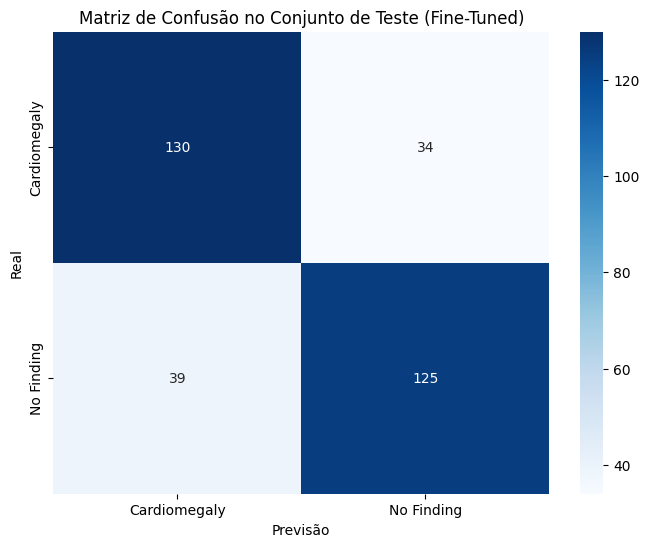

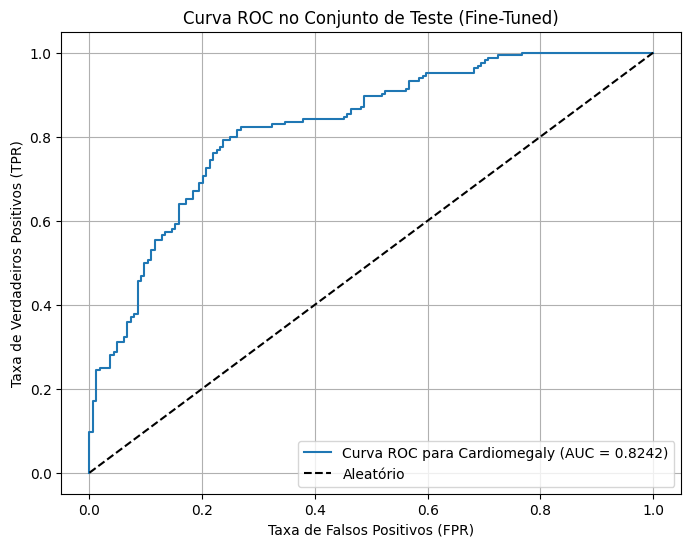


Avaliação completa do modelo fine-tuned no conjunto de teste.


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Definições de caminho (as mesmas dos passos anteriores)
model_save_path = '/content/models'
fine_tune_checkpoint_filepath = os.path.join(model_save_path, 'best_cardiomegaly_model_fine_tuned.keras')


# 1. Carregar o melhor modelo fine-tuned
print("\nCarregando o melhor modelo fine-tuned para avaliação final...")
try:
    best_fine_tuned_model = tf.keras.models.load_model(fine_tune_checkpoint_filepath)
    print("Modelo fine-tuned carregado com sucesso!")
except Exception as e:
    print(f"Erro ao carregar o modelo fine-tuned: {e}")
    print(f"Verifique se o arquivo '{fine_tune_checkpoint_filepath}' existe e o caminho está correto.")
    exit() # Interrompe a execução se o modelo não puder ser carregado

# 2. Avaliar o modelo no conjunto de teste
print("\nAvaliação no conjunto de Teste (Fine-Tuned Model):")
test_results_fine_tuned = best_fine_tuned_model.evaluate(test_generator, verbose=1)

print(f"\nFine-Tuned Test Loss: {test_results_fine_tuned[0]:.4f}")
print(f"Fine-Tuned Test Accuracy: {test_results_fine_tuned[1]:.4f}")
# As métricas de precision, recall, e auc_roc são as 3, 4, 5 posições
print(f"Fine-Tuned Test Precision: {test_results_fine_tuned[2]:.4f}")
print(f"Fine-Tuned Test Recall: {test_results_fine_tuned[3]:.4f}")
print(f"Fine-Tuned Test AUC-ROC: {test_results_fine_tuned[4]:.4f}")

# 3. Gerar previsões no conjunto de teste para métricas mais detalhadas
print("\nGerando previsões para o conjunto de Teste (Fine-Tuned Model)...")
test_generator.reset() # Garante que o gerador está no início
y_pred_probs_fine_tuned = best_fine_tuned_model.predict(test_generator, verbose=1)
y_pred_fine_tuned = np.argmax(y_pred_probs_fine_tuned, axis=1)

# Obter as classes reais e mapear para nomes
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
class_names_inv = {v: k for k, v in test_generator.class_indices.items()} # Mapeamento inverso
y_true_names = [class_names_inv[label] for label in y_true]
y_pred_fine_tuned_names = [class_names_inv[label] for label in y_pred_fine_tuned]

# 4. Relatório de Classificação Detalhado
print("\nRelatório de Classificação no Teste (Fine-Tuned Model):")

print(classification_report(y_true_names, y_pred_fine_tuned_names, target_names=class_names, zero_division=0))

conf_matrix_fine_tuned = confusion_matrix(y_true_names, y_pred_fine_tuned_names, labels=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_fine_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão no Conjunto de Teste (Fine-Tuned)')
plt.show()


y_score = y_pred_probs_fine_tuned[:, test_generator.class_indices['Cardiomegaly']]

y_true_cardiomegaly_binary = (y_true == test_generator.class_indices['Cardiomegaly']).astype(int)
y_score_cardiomegaly = y_pred_probs_fine_tuned[:, test_generator.class_indices['Cardiomegaly']]

auc_roc_cardiomegaly = roc_auc_score(y_true_cardiomegaly_binary, y_score_cardiomegaly)
fpr_cardiomegaly, tpr_cardiomegaly, thresholds_cardiomegaly = roc_curve(y_true_cardiomegaly_binary, y_score_cardiomegaly)


plt.figure(figsize=(8, 6))
plt.plot(fpr_cardiomegaly, tpr_cardiomegaly, label=f'Curva ROC para Cardiomegaly (AUC = {auc_roc_cardiomegaly:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC no Conjunto de Teste (Fine-Tuned)')
plt.legend()
plt.grid(True)
plt.show()

print("\nAvaliação completa do modelo fine-tuned no conjunto de teste.")

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
import io
from PIL import Image # Importar Pillow para redimensionamento e conversão

# Definições de caminho e parâmetros
model_save_path = '/content/models'
fine_tune_checkpoint_filepath = os.path.join(model_save_path, 'best_cardiomegaly_model_fine_tuned.keras')

IMG_HEIGHT = 224
IMG_WIDTH = 224
class_names = ['Cardiomegaly', 'No Finding'] # Garanta que a ordem das classes corresponda ao seu treinamento (0: Cardiomegaly, 1: No Finding)

# 1. Carregar o modelo fine-tuned
print("Carregando o modelo fine-tuned para previsão...")
try:
    model_for_prediction = tf.keras.models.load_model(fine_tune_checkpoint_filepath)
    print("Modelo carregado com sucesso!")
except Exception as e:
    print(f"Erro ao carregar o modelo: {e}")
    print(f"Verifique se o arquivo '{fine_tune_checkpoint_filepath}' existe e o caminho está correto.")
    print("Se você reiniciou a sessão do Colab, pode precisar re-executar os Passos 3, 4 (revisado) e 5.")
    exit() # Interrompe a execução se o modelo não for encontrado

# 2. Fazer o upload das imagens
print("\nPor favor, faça o upload das imagens que você deseja testar (uma ou mais).")
uploaded = files.upload()

# 3. Processar e prever para cada imagem carregada
for fn in uploaded.keys():
    print(f"\nProcessando imagem: {fn}")

    # Ler a imagem e converter para um array NumPy
    img_bytes = uploaded[fn]
    img = Image.open(io.BytesIO(img_bytes)).convert('RGB') # Abrir como imagem PIL e garantir RGB

    # Redimensionar a imagem para o tamanho esperado pelo modelo
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))

    # Converter para array NumPy e normalizar
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Adicionar dimensão de batch (1 imagem)
    img_array = img_array / 255.0 # Normalizar (igual ao ImageDataGenerator)

    # Fazer a previsão
    predictions = model_for_prediction.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100

    print(f"Previsão para '{fn}':")
    print(f"  Classe Predita: {predicted_class_name}")
    print(f"  Confiança: {confidence:.2f}%")

    # Exibir probabilidades para ambas as classes
    for i, prob in enumerate(predictions[0]):
        print(f"  Probabilidade de {class_names[i]}: {prob*100:.2f}%")

Carregando o modelo fine-tuned para previsão...
Modelo carregado com sucesso!

Por favor, faça o upload das imagens que você deseja testar (uma ou mais).


Saving teste.png to teste (2).png

Processando imagem: teste (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Previsão para 'teste (2).png':
  Classe Predita: No Finding
  Confiança: 51.65%
  Probabilidade de Cardiomegaly: 48.35%
  Probabilidade de No Finding: 51.65%
